In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import least_squares

In [2]:
def average_rows(x,nblock=100):
    nr=x.shape[0]//nblock
    nc=x.shape[1]
    y=np.zeros((nr,nc),dtype=x.dtype)
    for i in range(nr):
        y[i,:]=np.mean(x[i*nblock:(i+1)*nblock],axis=0)
    return y

In [3]:
def get_adev(x,tau,stidx=0,endidx=None):
    dt=4096/250e6
    delta=int(tau/dt)
#     print(delta)
    sl=slice(stidx,endidx,delta)
    samps=x[sl]
#     print(samps)
    adev=np.sqrt(np.mean((samps[2:]-2*samps[1:-1]+samps[:-2])**2)/(2*tau**2))
    return adev

In [4]:
with np.load("../spectra_1830_1840_4096_clock_with_correct_adev.npz") as f:
    spec1=f['spectra1']
    spec2=f['spectra2']
    delays=f['delays']

In [5]:
spec1.shape, spec2.shape

((50000, 10), (50000, 10))

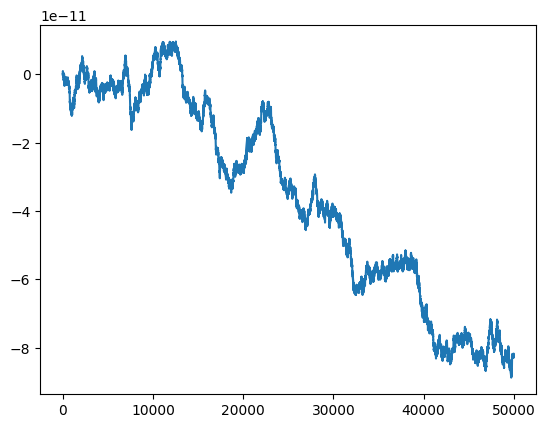

In [8]:
plt.plot(delays)

In [6]:
taus=10**np.linspace(-3,0,101)
# taus=np.linspace(0.1,2,1001)
adevs=np.zeros(len(taus))
for i,tau in enumerate(taus):
    adevs[i]=get_adev(delays,tau)

/home/mohan/.envs/xcorr/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mohan/.envs/xcorr/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


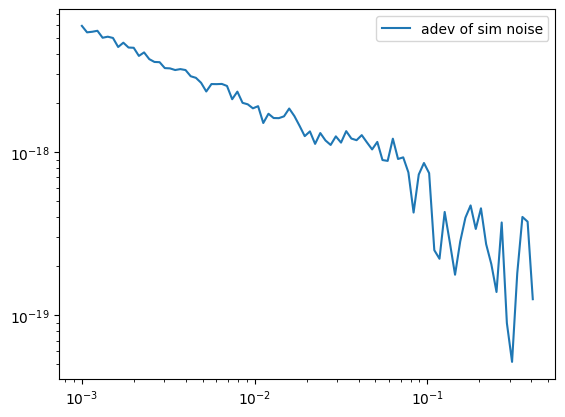

In [7]:
plt.loglog(taus,adevs*4e-9,label='adev of sim noise')
# params=np.polyfit(np.log10(taus), np.log10(adevs),2)
# plt.loglog(taus,10**np.polyval(params,np.log10(taus))*4e-9,label='quadratic fit')
plt.legend()
#4 to 5 OOM worse than actual LB ADEV. 

In [139]:
6e-7*1e-2/4e-9 #rough error in number of samples tau * adev(tau), for about 1000 spectra.

1.5

-1.6880404834558033e-14 6.043243189891345e-10


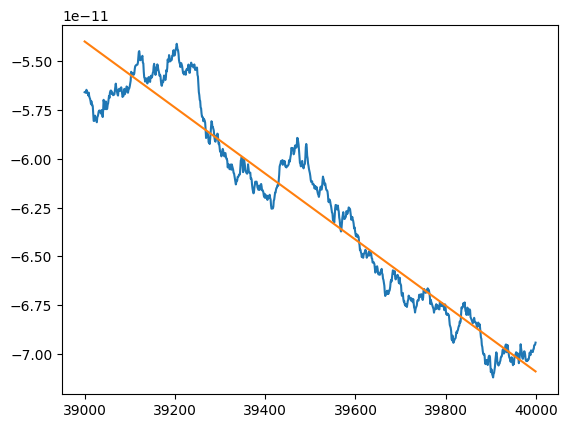

In [16]:
st=39000
en=40000
plt.plot(np.arange(st,en),delays[st:en])
m,c=np.polyfit(np.arange(st,en),delays[st:en],1)
# m,c=np.polyfit(np.arange(0,en-st),delays[st:en]-delays[st],1)
print(m,c)
plt.plot(np.arange(st,en), np.arange(st,en)*m+c)
# plt.xlim(20000,50000)

In [ ]:
#resolution with 50000 fft size is
1/(50000 * 1834) #min slope in units of spec/spec

1.0905125408942202e-08

In [ ]:
1/(50000 * 1834) * 4096/250e6 #slope units seconds per spectrum; minimum detectable by FFT length

1.7866957470010905e-13

In [111]:
def newton(n,xc,alpha,chan,scale=1):
    c=2*np.pi*chan
    N=len(xc)
    xc_phased = xc*np.exp(1j*c*n*alpha) #n is specnum
    S0conj=np.conj(np.mean(xc_phased))
    S1=np.mean(xc_phased*n*c)
    S2=np.mean(xc_phased*n**2*c**2)
    df=-np.imag(S0conj*S1)
    ddf=-np.real(S0conj*S2) + np.abs(S1)**2
    alpha2 = alpha - scale*df/ddf
    print(f"old alpha {alpha:5.3e}, df {df:5.3e}, ddf {ddf:5.3e}, step size {df/ddf:5.3e} new alpha {alpha2:5.3e} ")
    return alpha2

def solver(xc,alpha,chan,scale=1,atol=1e-10,rtol=1e-6,niter=10):
    niter=niter
    success=0
    N=len(xc)
    n = np.arange(N)
    for i in range(niter):
        alpha2=newton(n,xc,alpha,chan,scale=scale)
        if np.abs(alpha2) < atol:
            print("atol hit")
            success=1
            break
        if np.abs((alpha2-alpha)/alpha) < rtol:
            print("rtol hit")
            success=1
            break
        alpha=alpha2
    if not success:
        print("Max iterations, unsuccessful.")
    return alpha2

In [112]:
def objective_func(xc,alpha,chan):
    c=2*np.pi*chan
    N=len(xc)
    n=np.arange(N)
    xc_phased = xc*np.exp(1j*c*n*alpha)
    return np.abs(np.mean(xc_phased))**2

def get_derivs(xc,alpha,chan):
    c=2*np.pi*chan
    N=len(xc)
    n=np.arange(N)
    xc_phased = xc*np.exp(1j*c*n*alpha)
    S0conj=np.conj(np.mean(xc_phased))
    S1=np.mean(xc_phased*n*c)
    S2=np.mean(xc_phased*n**2*c**2)
    df=-np.imag(S0conj*S1)
    ddf=-np.real(S0conj*S2) + np.abs(S1)**2
    return df, ddf

(1.5895653388501696+3.0422827263025587e-05j)
(1.5895653388501696+3.0422827263025587e-05j)


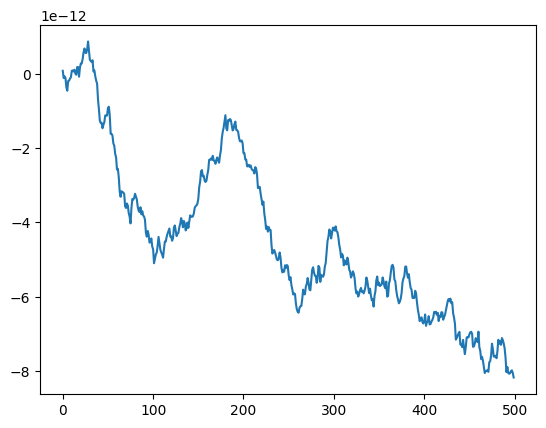

In [146]:
st=3500
en=4000
y1=spec1[st:en,4]
y2=spec2[st:en,4]
xc_small = y1*np.conj(y2)
print(np.mean(xc_small))
xc_small = xc_small #* np.exp(-1j*np.angle(xc_small)[0]) #a constant phase offset is not what we care about
# print(np.angle(xc_small))
print(np.mean(xc_small))
plt.plot(delays[st:en])
#whether or not FFT will be useful depends on whether we can resolve the slow sine wave across the chunk being FFT'ed.

500
Max at 0.0
Expected delta= 0.0


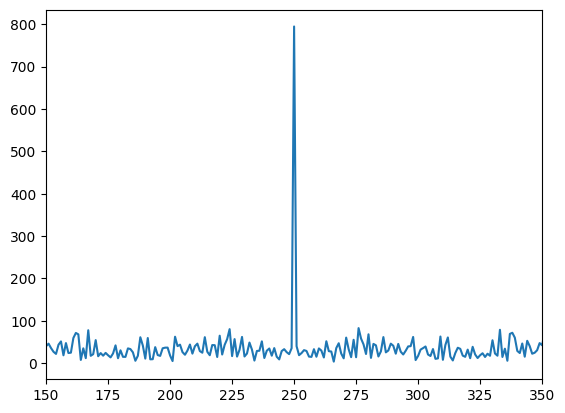

In [147]:
#take an fft to see which value to try.
xc_fft = np.fft.fftshift(np.abs(np.fft.fft(xc_small))) # should peak at -ve freq cause deltat is 2.5e-4, and fft is exp(-jomega t)
mm=np.argmax(xc_fft)
plt.plot(xc_fft)
plt.xlim(mm-100,mm+100)
M=len(xc_fft)
print(M)
print("Max at", mm-len(xc_fft)/2)
expected_delta = (mm-M/2)/M * (4096/1834)
print("Expected delta=", expected_delta)

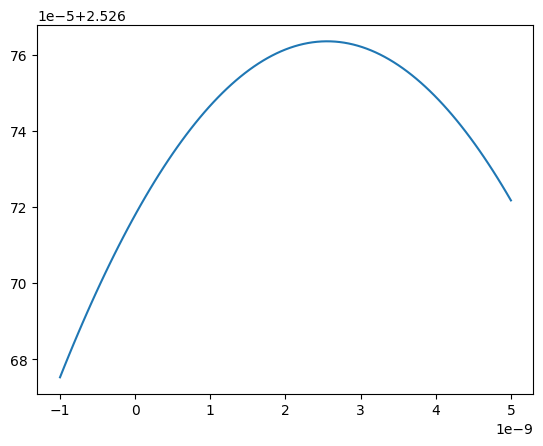

In [149]:
alphas=np.linspace(-1e-9,5e-9,101)
f_alpha = np.zeros(len(alphas))
df = f_alpha.copy()
ddf = f_alpha.copy()
for i in range(len(f_alpha)):
    f_alpha[i] = objective_func(xc_small,alphas[i],1834)
    df[i], ddf[i] = get_derivs(xc_small,alphas[i],1834)
plt.plot(alphas,f_alpha)

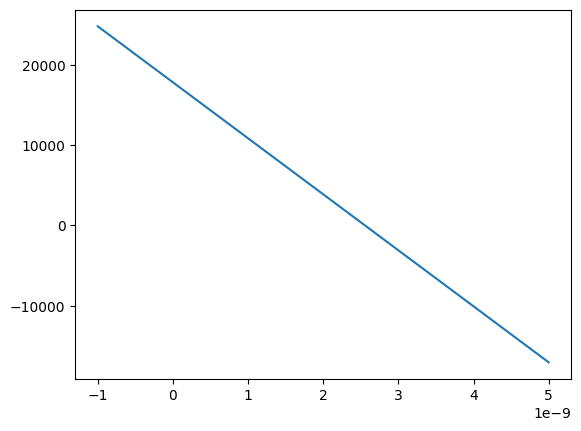

In [150]:
plt.plot(alphas,df)

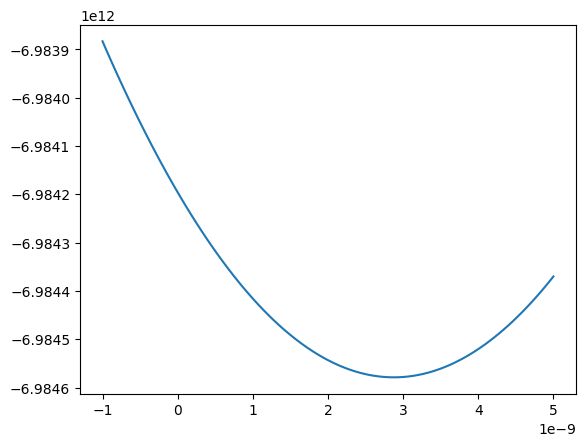

In [151]:
plt.plot(alphas,ddf)
# plt.xlim(-1.5e-10,1.5e-10)

In [116]:
print(ddf)

[-3.10893822e+13 -3.10894107e+13 -3.10894385e+13 -3.10894657e+13
 -3.10894922e+13 -3.10895180e+13 -3.10895431e+13 -3.10895676e+13
 -3.10895914e+13 -3.10896145e+13 -3.10896369e+13 -3.10896587e+13
 -3.10896799e+13 -3.10897003e+13 -3.10897201e+13 -3.10897392e+13
 -3.10897576e+13 -3.10897754e+13 -3.10897925e+13 -3.10898090e+13
 -3.10898247e+13 -3.10898398e+13 -3.10898543e+13 -3.10898680e+13
 -3.10898811e+13 -3.10898935e+13 -3.10899053e+13 -3.10899164e+13
 -3.10899268e+13 -3.10899365e+13 -3.10899456e+13 -3.10899540e+13
 -3.10899617e+13 -3.10899688e+13 -3.10899752e+13 -3.10899809e+13
 -3.10899860e+13 -3.10899904e+13 -3.10899941e+13 -3.10899972e+13
 -3.10899995e+13 -3.10900013e+13 -3.10900023e+13 -3.10900027e+13
 -3.10900024e+13 -3.10900014e+13 -3.10899998e+13 -3.10899975e+13
 -3.10899945e+13 -3.10899909e+13 -3.10899866e+13 -3.10899816e+13
 -3.10899759e+13 -3.10899696e+13 -3.10899626e+13 -3.10899550e+13
 -3.10899467e+13 -3.10899377e+13 -3.10899280e+13 -3.10899177e+13
 -3.10899067e+13 -3.10898

In [117]:
alpha=-1e-10
solver(xc_small,alpha,1834,rtol=1e-6,atol=1e-16,niter=100)

old alpha -1.000e-10, df -1.060e+03, ddf -3.109e+13, step size 3.409e-11 new alpha -1.341e-10 
old alpha -1.341e-10, df 2.665e-05, ddf -3.109e+13, step size -8.571e-19 new alpha -1.341e-10 
rtol hit


np.float64(-1.340931375904644e-10)

In [44]:
m / (16e-6)

np.float64(-1.0550253021598771e-09)

In [33]:
m_fit = -1.341e-10 * 4096/250e6
print(m,m_fit)

-1.6880404834558033e-14 -2.1970944e-15


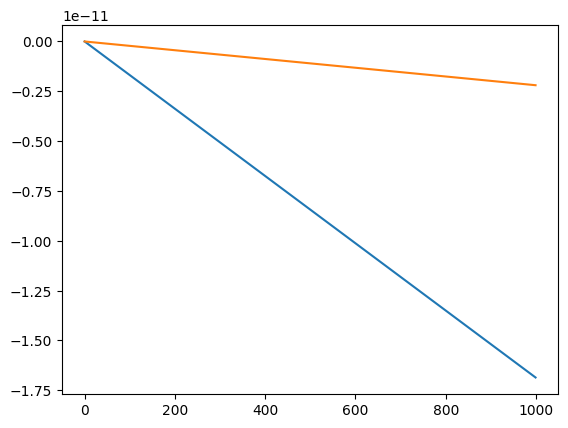

In [34]:
plt.plot(np.arange(0,en-st), np.arange(0,en-st)*m)
plt.plot(np.arange(0,en-st), np.arange(0,en-st)*m_fit)

In [129]:
#iterate over several blocks and fit a line
blocksize=500
st=0
nblocks=spec1.shape[0]//blocksize
en=blocksize*nblocks
fit_delta=np.zeros(nblocks,dtype='float64')
actual_delta = np.zeros(nblocks,dtype='float64')
for i in range(nblocks):
    #fft and get a coarse guess
    ix=st+i*blocksize
    y1=spec1[ix:ix+blocksize,4]
    y2=spec2[ix:ix+blocksize,4]
    xc_small = y1*np.conj(y2)
    xc_fft = np.fft.fftshift(np.abs(np.fft.fft(xc_small)))

    mm=np.argmax(xc_fft)
    # plt.plot(xc_fft)
    # plt.xlim(mm-100,mm+100)
    M=len(xc_fft)
    # print(M)
    # print("Max at", mm-len(xc_fft)/2)
    expected_delta = max((mm-M/2)/M * (4096/1834),1e-15)
    # print(f"Block {i} Expected delta={expected_delta}")
    alpha=solver(xc_small,expected_delta,1834,rtol=1e-4)
    fit_delta[i]=alpha
    # plt.title(f"Block {i}")
    # plt.plot(delays[ix:ix+blocksize])
    # plt.show()

    m,c=np.polyfit(np.arange(ix,ix+blocksize),delays[ix:ix+blocksize],1)
    # m,c=np.polyfit(np.arange(0,en-st),delays[st:en]-delays[st],1)
    print(f"block {i} slope", m, "pred slope", alpha*16e-6)
    actual_delta[i] = m

old alpha 1.000e-15, df 1.954e+04, ddf -7.807e+12, step size -2.502e-09 new alpha 2.502e-09 
old alpha 2.502e-09, df -6.303e-01, ddf -7.808e+12, step size 8.072e-14 new alpha 2.502e-09 
rtol hit
block 0 slope -4.08435061675389e-15 pred slope 4.003599679580545e-14
old alpha 1.000e-15, df -1.721e+04, ddf -7.188e+12, step size 2.395e-09 new alpha -2.395e-09 
old alpha -2.395e-09, df 4.436e-01, ddf -7.188e+12, step size -6.172e-14 new alpha -2.395e-09 
rtol hit
block 1 slope -2.3739280579032858e-14 pred slope -3.8312616781617993e-14
old alpha 1.000e-15, df 1.699e+03, ddf -7.507e+12, step size -2.263e-10 new alpha 2.263e-10 
old alpha 2.263e-10, df 2.691e-04, ddf -7.507e+12, step size -3.585e-17 new alpha 2.263e-10 
rtol hit
block 2 slope 1.5604498541102277e-14 pred slope 3.6214221514228755e-15
old alpha 1.000e-15, df -3.286e+03, ddf -8.653e+12, step size 3.798e-10 new alpha -3.798e-10 
old alpha -3.798e-10, df 2.448e-03, ddf -8.653e+12, step size -2.829e-16 new alpha -3.798e-10 
rtol hit
b

2.5542654062079325e-09 -8.358727668893401e-10


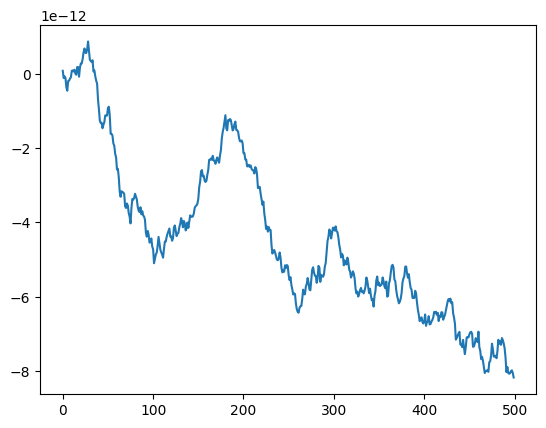

In [153]:
ii=7
plt.plot(delays[ii*blocksize:(ii+1)*blocksize]) #I BELIEVE DELAYS ARE ESSENTIALLY -ve of what the PHASE GIVES. phase will be -2 pi nu tau, and we are plotting tau
print(fit_delta[ii], actual_delta[ii]/16e-6)

In [156]:
xc_corrected = xc_small*np.exp(2j*np.pi*1834*np.arange(0,blocksize)*2.55e-9)
print(np.abs(np.mean(xc_corrected)))
xc_corrected = xc_small*np.exp(2j*np.pi*1834*np.arange(0,blocksize)*(-8.358e-10))
print(np.abs(np.mean(xc_corrected)))
print(np.abs(np.mean(xc_small)))

1.5895796727552536
1.5895544240605881
1.5895653391413018


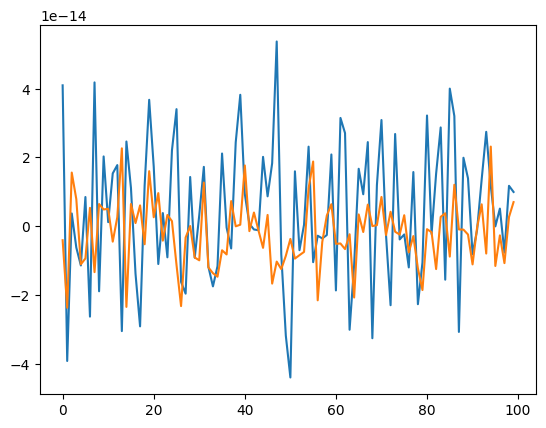

In [133]:
plt.plot(fit_delta*4096/250e6)
plt.plot(actual_delta)

np.float64(0.1)

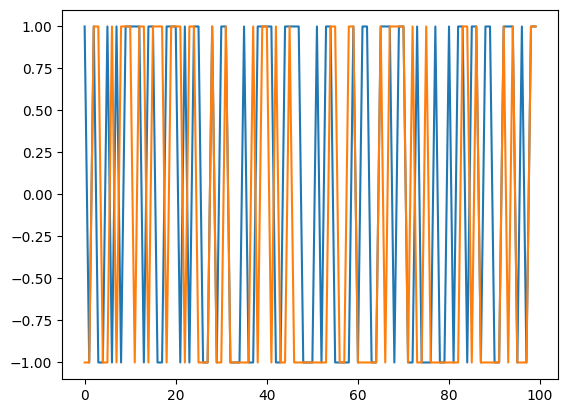

In [137]:
plt.plot(np.sign(fit_delta))
plt.plot(np.sign(actual_delta))
np.mean(np.sign(fit_delta)*np.sign(actual_delta))

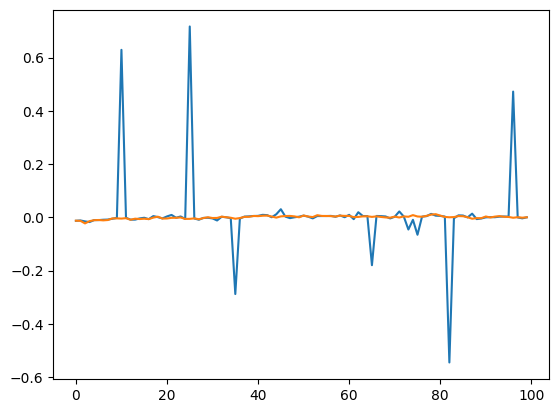

In [145]:
plt.plot(-fit_delta)
plt.plot(actual_delta) #this is with poor S/N and LOT of "flicker". We'll have less flicker and more S/N

In [ ]:
y1=spec1[:,4]
y2=spec2[:,4]
xc_small = y1*np.conj(y2)
#what's the avg without correcting anything
np.abs(np.mean(xc_small))

np.float64(1.6350968318899524)

In [74]:
#iterate over several blocks and fit a line
blocksize=1000
st=0
nblocks=50
en=blocksize*nblocks
fit_delta=np.zeros(nblocks,dtype='float64')
actual_delta = np.zeros(nblocks,dtype='float64')
n = np.arange(0,blocksize)
tot=0+0j
for i in range(nblocks):
    #fft and get a coarse guess
    ix=st+i*blocksize
    y1=spec1[ix:ix+blocksize,4]
    y2=spec2[ix:ix+blocksize,4]
    xc_small = y1*np.conj(y2)
    xc_small = xc_small * np.exp(-2j*np.pi*1834*n*actual_delta[i])
    tot+=np.mean(xc_small)
print("avg after correction", np.abs(tot/nblocks))

avg after correction 1.635096831889952


In [ ]:
pred_drift=np.zeros(nblocks*blocksize)
t = np.arange(blocksize)
for i in range(nblocks):
    pred_drift[i*blocksize : (i+1)*blocksize] = pred_drift[i*blocksize-1] - 2*np.pi*1834*t*fit_delta[i]/4096

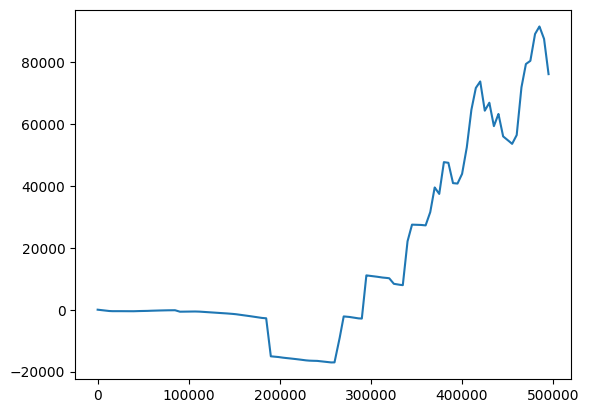

In [87]:
st=0
en=None
plt.plot(pred_drift[st:en])

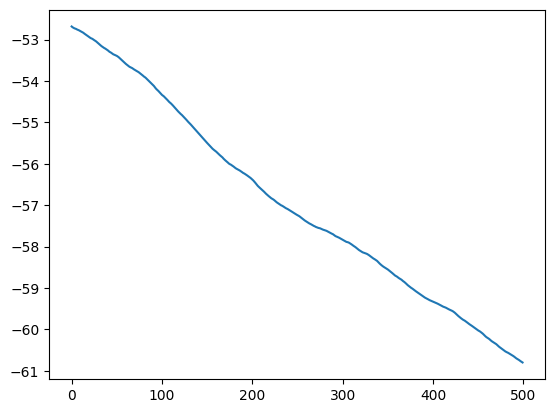

In [95]:
st=7000
en=7500
plt.plot(delays[st:en])